In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt

2024-05-19 14:23:02.137419: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 14:23:02.137568: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 14:23:02.139641: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 14:23:02.165122: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 14:23:02.576163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data paths
train_data_dir = "data/train"
valid_data_dir = "data/valid"
test_data_dir = "data/test"
categories = ["fresh", "half-fresh", "spoiled"]

# Define image dimensions
img_width, img_height = 640, 640

# Data generators for training and validation (test) data
train_datagen = ImageDataGenerator(rescale=1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

valid_datagen = ImageDataGenerator(rescale=1)


In [3]:
# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical',
    classes=categories)

valid_generator = valid_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical',
    classes=categories)

test_generator = valid_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    classes=categories)

Found 1715 images belonging to 3 classes.
Found 201 images belonging to 3 classes.
Found 201 images belonging to 3 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [5]:
# Define the CNN model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(categories), activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adagrad(),
              metrics=['accuracy'])

2024-05-19 14:23:03.182820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-19 14:23:03.183009: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
# Train the model
history = model.fit(train_generator,
          epochs=20,
          validation_data=valid_generator)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 114s 967ms/step - accuracy: 0.5736 - loss: 1.0817 - val_accuracy: 0.8756 - val_loss: 0.2986
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 107s 952ms/step - accuracy: 0.8491 - loss: 0.3282 - val_accuracy: 0.9602 - val_loss: 0.1322
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 107s 951ms/step - accuracy: 0.9047 - loss: 0.2442 - val_accuracy: 0.9005 - val_loss: 0.2050
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 107s 953ms/step - accuracy: 0.9219 - loss: 0.1995 - val_accuracy: 0.9751 - val_loss: 0.0924
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 107s 958ms/step - accuracy: 0.9416 - loss: 0.1494 - val_accuracy: 0.9751 - val_loss: 0.0989
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 107s 955ms/step - accuracy: 0.9533 - loss: 0.1259 - val_accuracy: 0.9353 - val_loss: 0.1930
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 107s 952ms/step - accuracy: 0.9608 - loss: 0.1041 - val_accuracy: 0.9701 - val_loss: 0.0846
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 107s 955ms/step - accuracy: 0.9597 -

In [8]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9926 - loss: 0.0531
Test accuracy: 0.9950248599052429


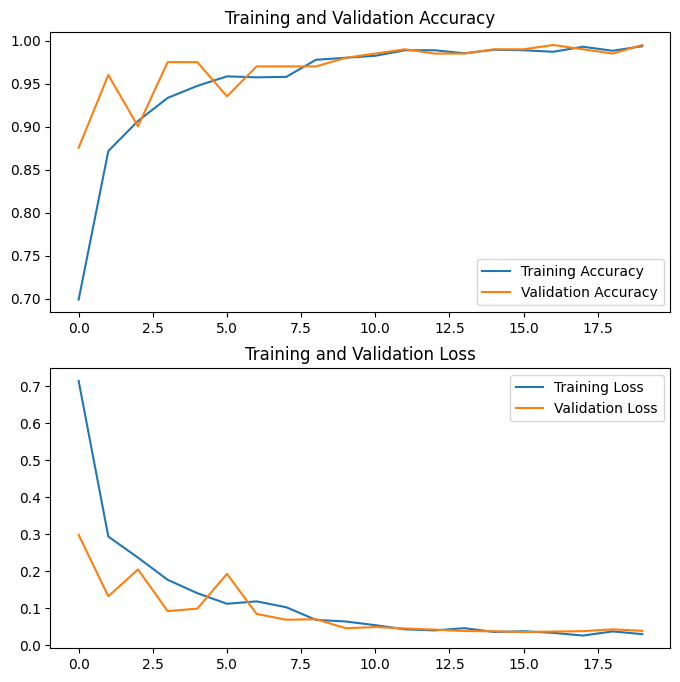

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.epoch, history.history['accuracy'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()